In [23]:
import tensorflow as tf
import numpy as np
import mavenn
import squid
import pandas as pd
import tqdm

In [24]:
class SquidWrapper(tf.keras.Model):
    """
    A small wrapper class to let CLIPNET predict on one-hot encoded sequences.
    """
    def __init__(self, base_model):
        super(SquidWrapper, self).__init__()
        self.base_model = base_model
        
    def call(self, inputs, training=False):
        # Multiply inputs by 2 before passing to the base model
        return self.base_model(inputs * 2, training=training)[0]
    
class ProfileEnsembler(tf.keras.Model):
    """
    A small wrapper class to average a bunch of models that have been passed through SquidWrapper.
    """
    def __init__(self, a_list_of_models):
        super(ProfileEnsembler, self).__init__()
        self.base_models = a_list_of_models
        
    def call(self, inputs, training=False):
        # Multiply inputs by 2 before passing to the base model
        return tf.expand_dims(tf.keras.layers.Average()([m(inputs) for m in self.base_models]), axis=-1)
    
def corr(x, y, pseudocount=1e-6):
    """
    Custom objective function that needs to be included when loading 
    CLIPNET instances.
    """
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x - mx, y - my
    num = tf.math.reduce_mean(tf.multiply(xm, ym))
    den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym) + pseudocount
    r = tf.math.maximum(tf.math.minimum(num / den, 1), -1)
    return r

def softmax_sum(x, save_dir=None):
    softmax = tf.keras.layers.Softmax()
    return tf.reduce_sum(tf.stop_gradient(softmax(x)) * x, axis=-1)

In [25]:
import os
model_path = "/home/adamyhe/github/clipnet/clipnet_models"
model_list = os.listdir(model_path)
print(model_list)

['fold_1.h5', 'fold_4.h5', 'fold_5.h5', 'fold_8.h5', 'fold_7.h5', 'fold_2.h5', 'fold_6.h5', 'fold_3.h5', 'fold_9.h5']


In [26]:
# Load and wrap models
models = ProfileEnsembler(
    [
        SquidWrapper(tf.keras.models.load_model(os.path.join(model_path, m), custom_objects={"corr": corr}))
        for m in tqdm.tqdm(model_list)
    ]
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.23s/it]


In [27]:
# Sequence of the IRF4 promoter in hg38. 2114 sequence taken for compatibility with
# ProCapNet and the PyTorch implementation of CLIPNET. We analyze the TF version
# of CLIPNET here, so we trim to just the middle 1kb
# >irf4_prom range=chr6:390663-392776 5'pad=0 3'pad=0 strand=+ repeatMasking=none
sequence = "GCTCACTGCAACTTCAGCCTCCCGGGTTCAAGCGATTCTCGTGGCTCGTCCTCTCAAGTAGCTGGGGCCACGCCCGGCTAATTTTTGTATTTTTAGTAGAGATGGGGTTTCACCGTGTTGGCCAGGCTGGTCTCGAACTCCTGACCTCAGGCGATCCACCGCCTCGGCCTCCCAAAGTGCTGGGATTACAGGCTTGAGCCACAGCGCCTGGCCTATTTTGGGCTTTTATACCCCACTGGTAAACTGCTTTCCTCCAGGTTGAGGTTAAAACGACATCATTTTAAGGTGAACTGAAGTCTGGAAGTGATTAAGCACTTGGATCCTTAGGGAGCCTCTCCCCGCCCCCATCTCTTTCATGCTAAGATAATTAAAACTTCGGGGCCGGGGCATTGTCTGAGTCACTTCAATTCACCAGCCTAATAGATGCAAAAGGATGTAAGCATGTCAGACACGCAGAGACAGTATTTGAATCAAGCTTAATAGCTCAAGGGAGCTGGGCCATTTCCTATTTTCTTTTTAGTGAGTGCGATGTTCTCTAAACACCGCGGAGAGGCAGGGTTCCCGGTGATGGCCTTGCCGAGGGTGCTCCCGCAACCTCCACCTCCAGTTCTCTTTGGACCATTCCTCCGTCTTCCGTTACACGCTCTGCAAAGCGAAGTCCCCTTCGCACCAGATTCCCGCTACTACACGCCCCCCATTTCCCGCCCTGGCCACATCGCTGCAGTTTAGTGATTGACTGGCCTCCTGAGGTCCTGGCGCAAAGGCGAGATTCGCATTTCGCACCTCGCCCTTCGCGGGAAACGGCCCCAGTGACAGTCCCCGAAGCGGCGCGCGCCCGGCTGGAGGTGCGCTCTCCGGGCGCGGCGCGCGGAGGGTCGCCAAGGGCGCGGGAACCCCACCCCGGCCGCGGCAGCCCCCAGCCTTCACGCCGGCCCTGAGGCTCGCCCGCCCGGCCGGCCCCGGCTCTCGGCTTGCAAAGTCCCTCTCCCCAGTCCAACCCCCGGCCCCCACAGGCCTCGGCGCCCCGCCCCGCCCCAGGCCCCGCCCCAGAGAGTTCTATAAAGTTCCTCTTTCCCACCTCGCACTCTCAGTTTCACCGCTCGATCTTGGGACCCACCGCTGCCCTCAGCTCCGAGTCCAGGGCGAGGTAAGGGCTGGAGTCGGGCAGGAGGAGGGGTGTGAGGCTGATACCAGAGAGGACCCGGAGCGCGAACCAGAGGTTCGACCTCCAGGGCAGCGCAGGGTACCCCGGCTTCGGAGCGGGAAGGGAGCGCGCCCCGTCCTGGAGCTCCGACTCCCACCCCATCTGCGCTGAGCCGGAGGCGCTGGTTTGGGCTCCAAGGCCCGCCTCCTTGGCTCTGCCCGAGCCTCCCCGCCTGCCCTCCGCGCTCCTGCGACGGGGTCGCCACAAGCTGGACGGGATGAGCTAACCGGACTGTCGGGGCCCCAGGAGTGGCTGAGGCGGGGCCGTCCAAGGCACCCACACAAGACGGCACAACTGCCTGCGAGAAACAGGCCCGGCCCTGTGGACCCCAATCCGAGGCTCCTTCCCCTGCTCTTCGTTCCTAAGGGGCCCAAGCTCACGGCGGCCTCCGGCGCGGTGCTCACCCGCTGGCGCAGGAGGAGGAGGAGCTCCACATTTGGGTCGCTCCGAGCCTTGCGTGCGGTGGCCTAGCCGGCCTGGCGCGGTCCCTGCCTCCCAGGCTCCGCAGCTGTCGTCGCCCTCTCCCGCGCCCTCCCCGCCTCCGCTCTCCCGGGCCTGCTCCGGGGTCCGGCGGACGCTCTGCGCGCGGAATCCCCCGTACTGGGGCTGCAGCCCCCGCGTCTGCGCCACTTGTCGTTTGCAGAGCCCACTTAGTGCGCGCTAGCTGGGCAGGGATAGGGGTCCTATTCGGGGCGAAGGGTCTGGATGCGAGCAGAGAAAGCGGAGGGTGGAGGAACCCGGGGCTGCGCCCCTGGAACGCCCGGCCGCAGGCGAGGTCCTCCGCGCGTGGAGGCCGCCAGGGGAGTGGAAACTGACAGAGTCGCGGGGAAGGGGCGAGAAGCGGGTTGGGAGTGAGCGAAGGCAAGCGAGAGCTGCGAGTGAGTGCGGAAGGAGGGCCAGGAGGGGTGGC"
seq = sequence[(len(sequence) - 1000) // 2 : -((len(sequence) - 1000) // 2)]
alphabet = ["A", "C", "G", "T"]
x = squid.utils.seq2oh(seq, alphabet)

In [28]:
# define mutagenesis window for sequence
start_position = 460
stop_position = 540

seq_length = x.shape[0]
mut_window = [start_position, stop_position]

In [29]:
# set up predictor class for in silico MAVE
pred_generator = squid.predictor.ProfilePredictor(
    pred_fun=models,
    batch_size=1024,
    task_idx=0,
    #reduce_fun=softmax_sum,
    reduce_fun=squid.predictor.profile_sum,
    #reduce_fun=squid.predictor.profile_pca,
)

In [30]:
# set up mutagenizer class for in silico MAVE
mut_generator = squid.mutagenizer.RandomMutagenesis(mut_rate=0.1, uniform=False)

# generate in silico MAVE
mave = squid.mave.InSilicoMAVE(mut_generator, pred_generator, seq_length, mut_window=mut_window)
x_mut, y_mut = mave.generate(x, num_sim=100_000)
tf.keras.backend.clear_session()


Building in silico MAVE...


Inference: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:39<00:00,  2.43it/s]


In [31]:
# plot histogram of transformed deepnet predictions
#fig = squid.impress.plot_y_hist(y_mut)

In [32]:
# delimit sequence to region of interest (required for pairwise computational constraints)
x_mut_trim = x_mut[:,mut_window[0]:mut_window[1],:]

In [40]:
# choose surrogate model type
gpmap = 'pairwise' #{'additive', 'pairwise' if MAVE-NN}

# MAVE-NN model with GE nonlinearity
surrogate_model = squid.surrogate_zoo.SurrogateMAVENN(
    x_mut_trim.shape,
    num_tasks=y_mut.shape[1],
    gpmap=gpmap,
    regression_type='GE',
    linearity='linear',
    noise='SkewedT',
    noise_order=2,
    reg_strength=0.1,
    alphabet=alphabet,
    deduplicate=True,
    gpu=True
)

In [41]:
# train surrogate model
surrogate, mave_df = surrogate_model.train(
    x_mut_trim,
    y_mut,
    learning_rate=5e-4,
    epochs=500,
    batch_size=100,
    early_stopping=True,
    patience=25,
    restore_best_weights=True,
    save_dir=None,
    verbose=1
)

# retrieve model parameters
params = surrogate_model.get_params(gauge='empirical')
tf.keras.backend.clear_session()

  Creating sequence dataframe...

               y                                                  x
0       3.164773  CGGCGCCCCGCCCCGCCCCAGGCCCCGCCCCAGAGAGTTCTATAAA...
1      21.709278  AGGAGCCCCGTCCCGCCCCAGGCCCCCCCCCAGAGAGTTCTATAAT...
2      20.689945  CGGTGCCCCGCCCCACCCCGGGCCGCGCCCCAGAGAGTTCCATAAC...
3      20.100090  CGGAGCCCCGCCGCGTCCCACGCCCCGCCGCAGAGAGTTCTATCAA...
4       2.707987  CGGCGCCCGGCCCCATCCCAGGCCCCGCCCCAGAGAGTTCTATATA...
...          ...                                                ...
99995  19.315292  CGGCGCCGCGACCCGCCCCACGCACCGCCCCAGAGAGGTCTCTAAG...
99996  21.711266  CGGCTCCTCGCCCCCCCCCAGGCACGGCCCCAGCGTGTTCAATAAC...
99997  13.242947  CGGCGTCCCGCCCCGCCCCTGGCCCCGAGCCAGAGAGTTCTATTAA...
99998   3.387015  CGGCGCCCCGCCCCGACCCAGACCCCGCCCCAGCGAGTTCTATAAA...
99999  16.735580  CGACTCCCCGCCCCGCCCAAGGCCCCGCCCCACAGAGTTCTACAAA...

[100000 rows x 2 columns]
Training set   :   59,963 observations (  60.06%)
Validation set :   19,875 observations (  19.91%)
Test set       :   20,0

  7%|██████████▌                                                                                                                                                | 34/500 [03:03<41:54,  5.40s/epoch, loss=-2.33, I_var=1.81, val_loss=66.7, val_I_var=0.814]

Training time: 183.7 seconds


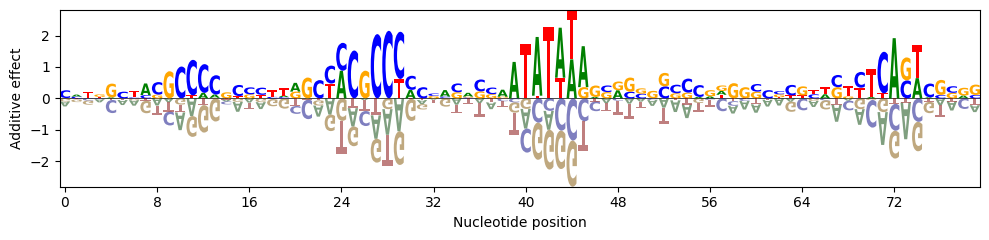

In [42]:
# plot additive logo   
fig = squid.impress.plot_additive_logo(params[1], center=True, view_window=None, alphabet=alphabet, fig_size=[10,2.5])
fig.savefig("irf4_prom_profile_sum_linear_additive.pdf")

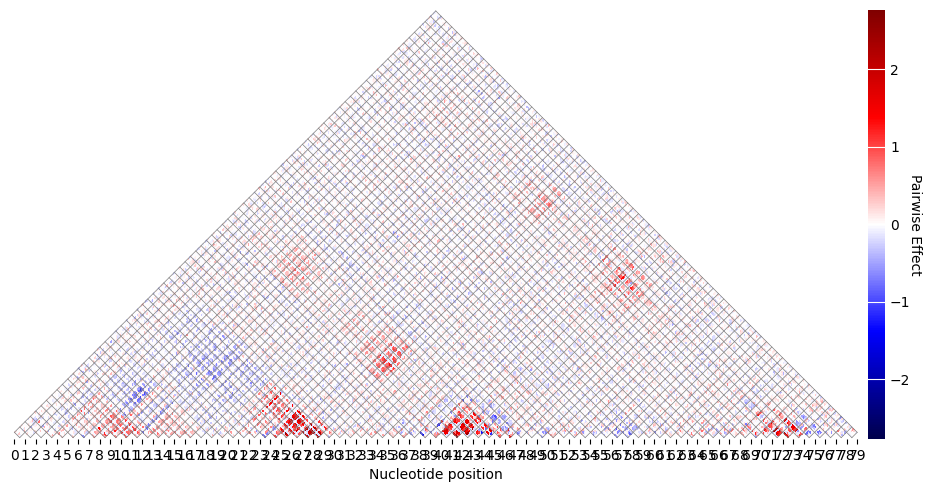

In [43]:
# plot pairwise matrix
fig = squid.impress.plot_pairwise_matrix(params[2], view_window=None, alphabet=alphabet)
fig.savefig("irf4_prom_profile_sum_linear_pairwise.pdf")

In [44]:
np.savez_compressed("irf4_prom_profile_sum_linear.npz", *params)